# Training and saving a model. 


In [1]:
from model import Generator, Discriminator
from latent_learner import LatentLearner
from dataset import Dataset
from tqdm import tqdm
import loss
import random

import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

import gc
import os

/home/ceng796/miniconda3/envs/796/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@torch.no_grad()
def save_samples(x_1, x_2, generator, latent_learner, iter_):
    os.makedirs("samples", exist_ok=True)

    generator.eval()
    latent_learner.eval()

    for i in range(len(x_1)):
        noise_1 = torch.unsqueeze(x_1[i], 0)
        noise_2 = torch.unsqueeze(x_2[i], 0)

        noise = torch.cat([noise_1, noise_2], axis=-1)
        # Map to latent
        w = latent_learner(noise)

        # Pass through Generator
        samples, _ = generator([w], input_is_latent=True)

        # Save for later examination
        torchvision.utils.save_image(
            samples.detach().clamp_(min=-1, max=1),
            f"samples/samples_{iter_}_{i}.png",
            nrow=1,
            normalize=True,
            range=(-1, 1),
        )

In [3]:
def disable_grad(model):
    for _, param in model.named_parameters():
        param.requires_grad = False

def train(device, max_iters=150):
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    generator = Generator(size=256, style_dim=512, n_mlp=8).to(device)
    discriminator = Discriminator(size=256).to(device)
    latent_learner = LatentLearner().to(device)

    vgg = torchvision.models.vgg19(weights='IMAGENET1K_V1').features.to(device).eval()

    # No need for gradients on the parameters of these
    disable_grad(generator)
    disable_grad(vgg)

    # Take sub-networks from the vgg, later used to compute style loss
    subnetworks = loss.subnetworks(vgg, max_layers=5)

    # Garbage collection
#    del vgg
#    gc.collect()
#    torch.cuda.empty_cache()

    # Load checkpoint and weights
    ckpt = torch.load("550000.pt")

    generator.load_state_dict(ckpt["g_ema"], strict=False)
    generator.eval()

    discriminator.load_state_dict(ckpt["d"])

    # Initialize optimizers (no optimizer for generator :)
    disc_opt = torch.optim.Adam(
        discriminator.parameters(),
        lr = 5e-4,
        betas = (0.0, 0.99)
    )
    latent_learner_opt = torch.optim.Adam(
        latent_learner.parameters(),
        lr = 5e-4,
        betas = (0.0, 0.99)
    )

    # Simple transformation pipeline
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((256, 256)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # style loss normalization
    style_norm = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Create simple dataset & loader
    x_1 = torch.randn(10, 14, 512, device=device)
    x_2 = torch.randn(10, 14, 512, device=device)

#    x = torch.randn(10, 14, 1024, device=device)

    dataset = Dataset(path="./babies", device=device, transforms=transforms)

    bar = tqdm(range(max_iters), dynamic_ncols=True)

    # 150 iterations
    for idx in bar:
        i = np.random.choice(10, size=4, replace=False)
        imgs = dataset[i]

#        noise = x[i]

        idx_1 = np.random.choice(10, size=imgs.shape[0], replace=False)
        idx_2 = np.random.choice(10, size=imgs.shape[0], replace=False)

        x = torch.cat([x_1[idx_1], x_2[idx_2]], axis=-1)

        ##### Adversarial Loss ##### 
        # first forward pass
        w = latent_learner(x)
#        w = latent_learner(noise)
        samples, _ = generator([w], input_is_latent=True)

        real_scores = discriminator(imgs)
        fake_scores = discriminator(samples)

        d_loss = loss.d_logistic_loss(real_scores, fake_scores)

        # optimization step on discriminator
        disc_opt.zero_grad()
        d_loss.backward()
        disc_opt.step()

        # second forward pass (needed)
        w = latent_learner(x)
#        w = latent_learner(noise)
        samples, _ = generator([w], input_is_latent=True)

        fake_scores = discriminator(samples)

        g_loss = 5 * (1 - idx/max_iters) * loss.g_nonsaturating_loss(fake_scores)

        # optimization step on latent learner
        latent_learner_opt.zero_grad()
        g_loss.backward()
        latent_learner_opt.step()

        ##### Style Loss #####
        idx_1 = np.random.choice(10, size=5, replace=False)
        img_idx = np.random.choice(10, size=idx_1.shape[0], replace=False)
        imgs = dataset[img_idx]

        x = torch.cat([x_1[idx_1], x_2[img_idx]], axis=-1)
        w = latent_learner(x)

        samples, _ = generator([w], input_is_latent=True)

        style_loss = 50 * loss.style_loss(subnetworks, style_norm(imgs), style_norm(samples))

        latent_learner_opt.zero_grad()
        style_loss.backward()
        latent_learner_opt.step()

        bar.set_description(f"d_loss: {d_loss.cpu():.2f}, g_loss: {g_loss.cpu():.2f}, style_loss: {style_loss:.2f}")

        if (idx+1) % 50 == 0:
            save_samples(x_1, x_2, generator, latent_learner, idx+1)

    return torch.cat([x_1, x_2], axis=-1), latent_learner, generator

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
noise, latent_learner, generator = train(device, max_iters=50)

d_loss: 0.07, g_loss: 0.41, style_loss: 1.69: 100%|█████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


In [6]:
os.makedirs("ckpts", exist_ok=True)

torch.save(noise, "ckpts/noise.pt")
torch.save(latent_learner.state_dict(), "ckpts/latent_learner.pt")
torch.save(generator.state_dict(), "ckpts/generator.pt")

# Loading a pre-trained model and computing qualitative samples/outputs from that model

In [7]:
generator = Generator(size=256, style_dim=512, n_mlp=8).to(device)
generator.load_state_dict(torch.load("ckpts/generator.pt"))
generator.eval()

latent_learner = LatentLearner().to(device)
latent_learner.load_state_dict(torch.load("ckpts/latent_learner.pt"))

noise = torch.load("ckpts/noise.pt")

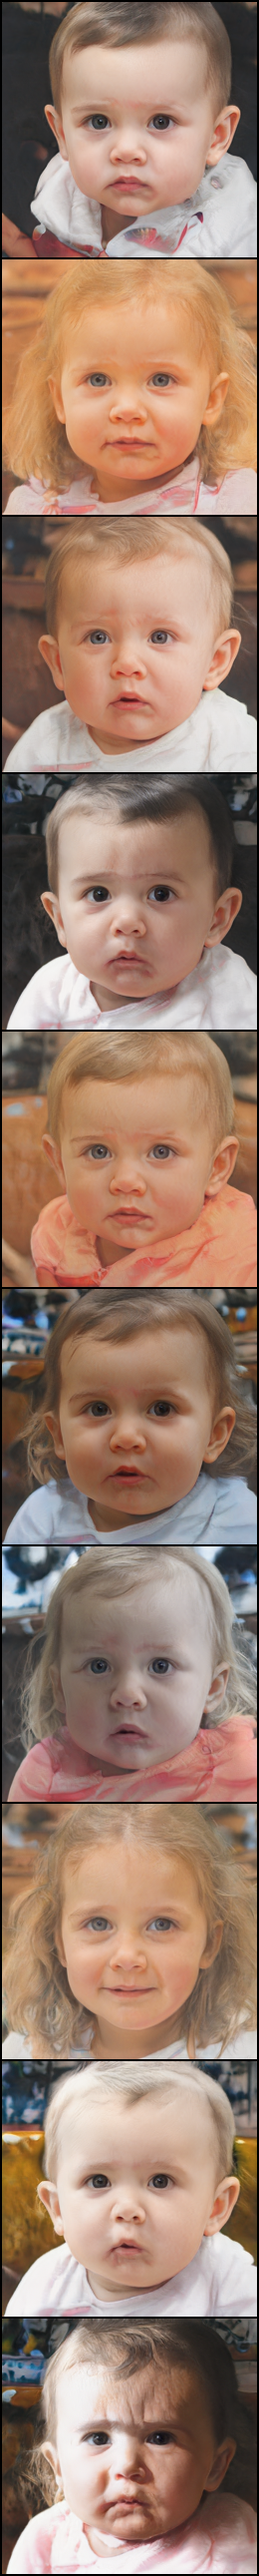

In [8]:
with torch.no_grad():
    # Map to latent
    w = latent_learner(noise)

    # Pass through Generator
    samples, _ = generator([w], input_is_latent=True)

    # Save for later examination
    torchvision.utils.save_image(
        samples.detach(),
        "samples.png",
        nrow=1,
        normalize=True,
        range=(-1, 1),
    )

    from PIL import Image

    display(Image.open("samples.png"))